# Global sensitivity analysis

Global sensitivity analysis is a Monte Carlo based method to rank the importance of parameters in a given modelling problem. As opposed to local senstivity analysis, it does not require the construction of the Jacobian, making it a flexible tool to evaluate complex problems.

Global sensitivty analysis is available in mainly uncertainty quantificaiton packages, as well as some flow and transport programs (e.g. iTOUGH2). GSA is also very popular in catchment modelling and civil engineering/risk analysis problems.

Some GSA work in hydrogeophysics (mainly by Berkeley Lab):

* coupled hydrological-thermal-geophysical inversion ([Tran et al 2017](https://www.hydrol-earth-syst-sci.net/20/3477/2016/hess-20-3477-2016.pdf))
> Nicely show how to simplify (i.e. reduce the number of parameters) for a very complex, highly coupled problem 
* making sense of global senstivity analysis ([Wainwright et al 2014](https://doi.org/10.1016/j.cageo.2013.06.006))
> Very good review article
* Sensitivity analysis of environmental models ([Pianosi et al 2014](https://doi.org/10.1016/j.envsoft.2016.02.008))
> A systematic review, includes GLUE and RSA
* hydrogeology of a nuclear site in the Paris Basin ([Deman et al 2016](https://doi.org/10.1016/j.ress.2015.11.005))
> A different GSA method was used instead here to look at the low probability breakthrough events
* Global Sensitivity and Data-Worth Analyses in iTOUGH2 User's Guide ([Wainwright et al 2016](http://eesatough.lbl.gov/assets/files/02/documentation/iTOUGH2-Sensitivity_Analysis.pdf))
> An useful manual if you want to learn about the details of setting up a probllem.

In this tutorial, we will see how to link the **RESiPy** API and **SALib** for senstivity analysis. Two key elements of SA are (i) forward modelling (Monte Carlo runs) and (ii) specifying the parameter ranges. This notebook will showcase of the use of the *Method of Morris*, which is known for its relatively small computational cost. This tutorial is modified from the one posted on https://github.com/SALib/SATut to demonstrate its coupling with **RESiPy**

## Morris sensitivity method
>The Morris one-at-a-time (OAT) method (Morris, 1991) can be considered as an extension of the local sensitivity method. Each parameter range is scaled to the unit interval [0, 1] and partitioned into $(p−1)$ equally-sized intervals. The reference value of each parameter is selected randomly from the set ${0, 1/(p−1), 2/(p−1), …, 1−Δ}$. The fixed increment $Δ=p/{2(p−1)}$ is added to each parameter in random order to compute the elementary effect ($EE$) of $x_i$


$$EE_i=\frac{1}{\tau_y}\frac{f(x_1*,...,x_i*+\Delta,...,x_k*)-f(x_1*,...,x_k*)}{\Delta}$$

> where ${x_i⁎}$ is the randomly selected parameter set, and τy is the output-scaling factor. To compute EEi for k parameters, we need (k+1) simulations (called one “path”) in the same way as that of the local sensitivity method. By having multiple paths, we have an ensemble of EEs for each parameter. The total number of simulations is r(k+1), where r is the number of paths.

We compute three statistics: the mean $EE$, standard deviation (STD) of $EE$, and mean of absolute $EE$. 
* **mean EE ($\mu$)** represents the average effect of each parameter over the parameter space, the mean EE can be regarded as a global sensitivity measure.
* **mean |EE| ($\mu*$)** is used to identify the non-influential factors, 
* **STD of EE ($\sigma$)** is used to identify nonlinear and/or interaction effects. (The standard error of mean (SEM) of EE, defined as $SEM=STD/r^{0.5}$, is used to calculate the confidence interval of mean EE (Morris, 1991))

This cell is copied from ([Wainwright et al 2014](https://www.sciencedirect.com/science/article/pii/S0098300413001702))

## Importing libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import sys
sys.path.append((os.path.relpath('../src'))) # add here the relative path of the API folder

import numpy as np # numpy for electrode generation
import pandas as pd
from IPython.utils import io  # suppress R2 outputs during MC runs
from resipy import R2


API path =  /media/jkl/data/phd/tmp/pyr2/src/resipy
ResIPy version =  2.0.1


### The SALib package
SALib is a **free** **open-source** **Python** library



If you use Python, you can install it by running the command

```python
pip install SALib
```

[Documentation](http://salib.readthedocs.org/) is available online and you can also view the code on [Github](http://salib.github.io/SALib/).

The library includes:
* Sobol Sensitivity Analysis ([Sobol 2001](http://www.sciencedirect.com/science/article/pii/S0378475400002706), [Saltelli 2002](http://www.sciencedirect.com/science/article/pii/S0010465502002801), [Saltelli et al. 2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087))
* Method of Morris, including groups and optimal trajectories ([Morris 1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804), [Campolongo et al. 2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805))
* Fourier Amplitude Sensitivity Test (FAST) ([Cukier et al. 1973](http://scitation.aip.org/content/aip/journal/jcp/59/8/10.1063/1.1680571), [Saltelli et al. 1999](http://amstat.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594))
* Delta Moment-Independent Measure ([Borgonovo 2007](http://www.sciencedirect.com/science/article/pii/S0951832006000883), [Plischke et al. 2013](http://www.sciencedirect.com/science/article/pii/S0377221712008995))
* Derivative-based Global Sensitivity Measure (DGSM) ([Sobol and Kucherenko 2009](http://www.sciencedirect.com/science/article/pii/S0378475409000354))
* Fractional Factorial Sensitivity Analysis ([Saltelli et al. 2008](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470059974.html))

[SALib Tutorial](https://github.com/SALib/SATut)

In [2]:
# import the packages
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

### Create ERT forward problem with **ResIPy**

In the code below, created a R2 forward problem to be analyzed

Working directory is: /media/jkl/data/phd/tmp/pyr2/src/resipy/invdir
clearing the dirname
computed DOI : -7.67
Using a quadrilateral mesh.
written mesh.dat file to 
/media/jkl/data/phd/tmp/pyr2/src/resipy/invdir/mesh.dat
Writing .in file...
done

Writing protocol.dat ...
done

Running forward model


 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v3.3 <<

 >> D a t e : 19 - 11 - 2019
 >> My beautiful survey
 >> F o r w a r d   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from resistivity.dat

 Measurements read:   165     Measurements rejected:     0

 >> Total Memory required is:          0.395 Gb
Inf or NaN: filterData: 0 / 165 quadrupoles removed.
strange quadrupoles: filterData: 0 / 165 quadrupoles removed.
165/165 reciprocal measurements NOT found.
0 measurements error > 20 %
computed DOI : -3.67
computed DOI : -3.67
F

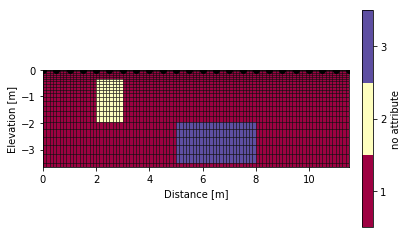

In [3]:
k = R2()

elec = np.zeros((24,3))
elec[:,0] = np.arange(0, 24*0.5, 0.5) # with 0.5 m spacing and 24 electrodes
k.setElec(elec)
#print(k.elec)

# defining electrode array
x = np.zeros((24, 3))
x[:,0] = np.arange(0, 24*0.5, 0.5)
k.setElec(elec)

# creating mesh
k.createMesh(res0=20)

# add region
k.addRegion(np.array([[2,-0.3],[2,-2],[3,-2],[3,-0.3],[2,-0.3]]), 50)
k.addRegion(np.array([[5,-2],[5,-3.5],[8,-3.5],[8,-2],[5,-2]]), 500)

# define sequence
k.createSequence([('dpdp1', 1, 10)])

# forward modelling
k.forward(noise=0.025)

# read results
fwd_dir = os.path.relpath('../src/resipy/invdir/fwd')

obs_data = np.loadtxt(os.path.join(fwd_dir, 'R2_forward.dat'),skiprows =1)
obs_data = obs_data[:,6]

# plot
k.showMesh()

### Option to view resistivity fields with pyvista 


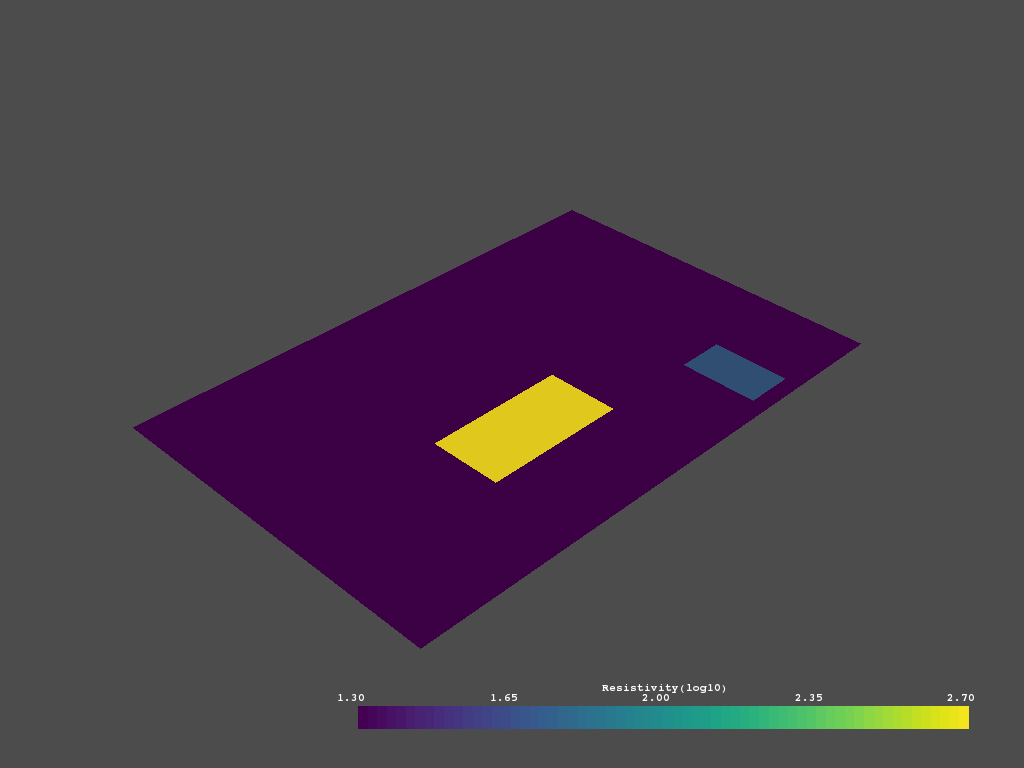

UnstructuredGrid (0x7f5d5c8cb6a8)
  N Cells:	2576
  N Points:	2697
  X Bounds:	0.000e+00, 1.150e+01
  Y Bounds:	-7.681e+00, 0.000e+00
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	2

In [5]:
import pyvista as pv
mesh = pv.read(os.path.join(fwd_dir, 'forward_model.vtk'))

mesh.cell_arrays
mesh.plot(scalars='Resistivity(log10)',notebook=True)
mesh

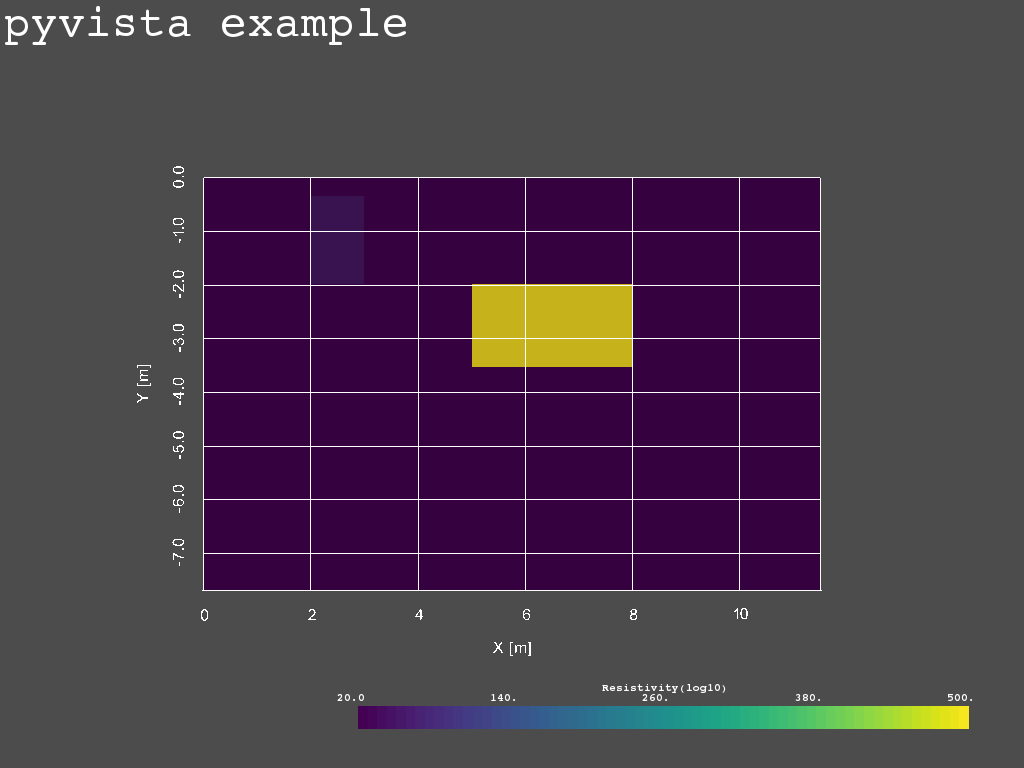

In [6]:
import pyvista as pv

plotter = pv.Plotter()
mesh = pv.read(os.path.join(fwd_dir, 'forward_model.vtk'))

plotter.add_mesh(mesh,cmap="viridis" ,stitle="Resistivity(log10)") #scalars='Resistivity(log10)'
#plotter.show_axes()

_ = plotter.show_bounds(grid='front', location='outer', all_edges=True, xlabel="X [m]",ylabel="Y [m]")
plotter.add_text('pyvista example')
#plotter.update_scalar_bar_range([-2000,2000], name="Resistivity(log10)")

#plotter.add_mesh(mesh, cmap="bone", opacity="linear", stitle="Linear Opacity")
plotter.view_xy()
plotter.show()
#plotter.show(screenshot='test.png')


### Define a problem file

In the code below, a problem file is used to define the parameters and their ranges we wish to explore, which corresponds to the following table:

|         Parameter        |  Range   |  Description   |
|--------------------------|----------|----------|
|   rho0 [ohm m]  | 10^[0.5,3.5] | background |
|   rho1 [ohm m]  | 10^[0.5,3.5] |inclusion A|
|   rho2 [ohm m]  | 10^[0.5,3.5] |inclusion B|


In [7]:
morris_problem = {
    'num_vars': 3,
    # These are their names
    'names': ['rho1', 'rho2', 'rho3'], # can add z1 z2 etc.
    # Plausible ranges over which we'll move the variables
    'bounds': [[0.5,3.5], # log10 of rho (ohm m)
               [0.5,3.5], 
               [0.5,3.5]#, 
   #            [-3,-1], 
   #            [-7,-4], 
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

### Generate a Sample

We then generate a sample using the `morris.sample()` procedure from the SALib package.

In [8]:
number_of_trajectories = 20
sample = ms.sample(morris_problem, number_of_trajectories, num_levels=10)
len(sample)
print(sample[79,:])


[0.5 3.5 3.5]


## Run the sample through the monte carlo procedure in R2
Great! You have defined your problem and have created a series of input files for forward runs. Now you need to run R2 for each of them to obtain their ERT responses.

For this example, each sample takes a few seconds to run on a PC.

In [9]:
#%%capture
simu_ensemble = np.zeros((len(obs_data),len(sample)))
for ii in range(0, len(sample)):
    with io.capture_output() as captured:          # suppress inline output from ResIPy
        # creating mesh
        k.createMesh(res0=10**sample[ii,0])   # need to use more effective method, no need to create mesh every time

        # add region
        k.addRegion(np.array([[2,-0.3],[2,-2],[3,-2],[3,-0.3],[2,-0.3]]), 10**sample[ii,1])
        k.addRegion(np.array([[5,-2],[5,-3.5],[8,-3.5],[8,-2],[5,-2]]), 10**sample[ii,2])

        # forward modelling
        k.forward(noise=0.025, iplot = False)
        out_data = np.loadtxt(os.path.join(fwd_dir, 'R2_forward.dat'),skiprows =1)
        simu_ensemble[:,ii] = out_data[:,6]
    print("Running sample",ii+1)

Running sample 1
Running sample 2
Running sample 3
Running sample 4
Running sample 5
Running sample 6
Running sample 7
Running sample 8
Running sample 9
Running sample 10
Running sample 11
Running sample 12
Running sample 13
Running sample 14
Running sample 15
Running sample 16
Running sample 17
Running sample 18
Running sample 19
Running sample 20
Running sample 21
Running sample 22
Running sample 23
Running sample 24
Running sample 25
Running sample 26
Running sample 27
Running sample 28
Running sample 29
Running sample 30
Running sample 31
Running sample 32
Running sample 33
Running sample 34
Running sample 35
Running sample 36
Running sample 37
Running sample 38
Running sample 39
Running sample 40
Running sample 41
Running sample 42
Running sample 43
Running sample 44
Running sample 45
Running sample 46
Running sample 47
Running sample 48
Running sample 49
Running sample 50
Running sample 51
Running sample 52
Running sample 53
Running sample 54
Running sample 55
Running sample 56
R

### Factor Prioritisation

We'll run a sensitivity analysis of the power module to see which is the most influential parameter.

The results parameters are called **mu**, **sigma** and **mu_star**.

* **Mu** is the mean effect caused by the input parameter being moved over its range.
* **Sigma** is the standard deviation of the mean effect.
* **Mu_star** is the mean absolute effect.

> The higher the mean absolute effect for a parameter, the more sensitive/important it is*

In [10]:
# Define an objective function: here I use the error weighted rmse
def obj_fun(sim,obs,noise):
    y = np.divide(sim-obs,noise)   # weighted data misfit
    y = np.sqrt(np.inner(y,y))
    return y

output = np.zeros((1,len(sample)))
for ii in range(0, len(sample)):
    output[0,ii] = obj_fun(simu_ensemble[:,ii],obs_data,0.025*obs_data)    # assume 2.5% noise in the data
    
# Store the results for plotting of the analysis
Si = ma.analyze(morris_problem, sample, output, print_to_console=False)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mean(EE)", "mean(|EE|)", "std(EE)"))
for name, s1, st, mean in zip(morris_problem['names'], 
                              Si['mu'], 
                              Si['mu_star'], 
                              Si['sigma']):
    print("{:20s} {:=7.3f} {:=7.3f} {:=7.3f}".format(name, s1, st, mean))

Name                 mean(EE) mean(|EE|) std(EE)
rho1                 44970.495 44970.495 46833.357
rho2                 674.923 720.549 2283.542
rho3                 481.407 483.971 609.766


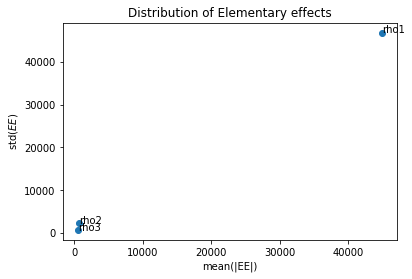

In [11]:
# make a plot
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.scatter(Si['mu_star'],Si['sigma'])
#ax.plot(Si['mu_star'],2*Si['sigma']/np.sqrt(number_of_trajectories),'--',alpha=0.5)
#ax.plot(np.array([0,Si['mu_star'][0]]),2*np.array([0,Si['sigma'][0]/np.sqrt(number_of_trajectories)]),'--',alpha=0.5)

plt.title('Distribution of Elementary effects')
plt.xlabel('mean(|EE|)')
plt.ylabel('std($EE$)')
for i, txt in enumerate(Si['names']):
    ax.annotate(txt, (Si['mu_star'][i], Si['sigma'][i]))
    
# higher mean |EE|, more important factor
# line within the dashed envelope means nonlinear or interaction effects dominant

## Summary


Sensitivity analysis helps you:

* Think through your assumptions
* Quantify uncertainty
* Focus on the most influential uncertainties first

Learn [Python](https://www.python.org)

Similar packages to [SALib]() for other languages/programmes:

* [Matlab Toolbox **SAFE** for GSA](http://www.sciencedirect.com/science/article/pii/S1364815215001188)
* [`sensitivity` package for R](https://cran.r-project.org/web/packages/sensitivity/index.html) (Michael used it for GSA in his leak detection paper)

In [12]:
# run this so that a navigation sidebar will bee generated when exporting this notebook as HTML
#%%javascript
#$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
#$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');